## Inversion einer Gleichstrom-Geoelektrik-Messung 

Dieses Programm invertiert eine Widerstandstiefenverteilung für gemessene Sondierungskurven.
 Die prinzipielle Vorgehensweise der Inversion wird im Folgenden kurz erklärt. 

Grundlage einer jeden Inversion sind eine Reihe von Messdaten *d* (in diesem Fall ihre Auslagenlängen und Spannungs- und Stromstärkemessungen) sowie ein Startmodell *m*. Das Startmodell sollte per Hand gewählt werden. In der Gleichstromgeoelektrik geht dies recht einfach anhand der Form der Messkurve. 

Als nächstes wird mit Hilfe des Modells eine *Vorwärtsrechnung* durchgeführt, d.h. es wird  für dieses Modell die Widerstands-Tiefenverteilung berechnet. Diesen Schritt kennen Sie bereits vom letzten Übungszettel. Anschließend wird der Unterschied zwischen Daten und Modellantwort berechnet. Dieser Fehler wird häufig *misfit* genannt und mit $\delta$ abgekürzt. 

Nun beginnt die eigentliche Inversion. Wir addieren zu unserem Modell *m* eine kleine (in diesem Fall zufällige) Modellveränderung $\Delta$m und erhalten ein neues Modell m$_{new}$. Auch für dieses Modell berechnen wir eine Vorwärtsrechnung und den Unterschied/*misfit* zwischen Daten und Modell und erhalten ein neues $\delta_{new}$ für unser neues Modell. 

Anschließend vergleichen wir $\delta_{new}$ und $\delta$. Hier gibt es zwei Möglichkeiten. 

- 1. $\delta_{new}$ ist kleiner als $\delta$, d.h. das neue Modell passt die Messdaten besser an, als das alte. Wir übernehmen deshalb das neue Modell und vergessen das alte Modell und gehen wieder zum ersten Schritt der Inversion, und berechnen ein neues Modellupdate
- 2. $\delta_{new}$ ist größer als $\delta$, d.h. das neue Modell passt die Messdaten schlecher an. Dann vergessen wir das neue Modell und behalten das alte Modell und gehen wieder zum ersten Schritt der Inversion, und berechnen ein neues zufälliges Modellupdate, in der Hoffnung, dass dieses die Daten dann besser anpasst. 

Auf diese Weise kann die Modellanpassung auschließlich besser werden oder gleich bleiben. 

Dieser Kreislauf wird eine *Iteration* der Inversion genannt. Diese Schritte werden so lange wiederholt, bis eine maximale Anzahl von Iterationen, die wir zuvor definieren müssen, erreicht ist. Dann speichern wir uns das letzte Modell als unser finales Modell, welche die Daten bestmöglich anpasst. 

Das folgende Organigramm fasst nochmal die wichtigsten Schritte der Inversion zusammen. 

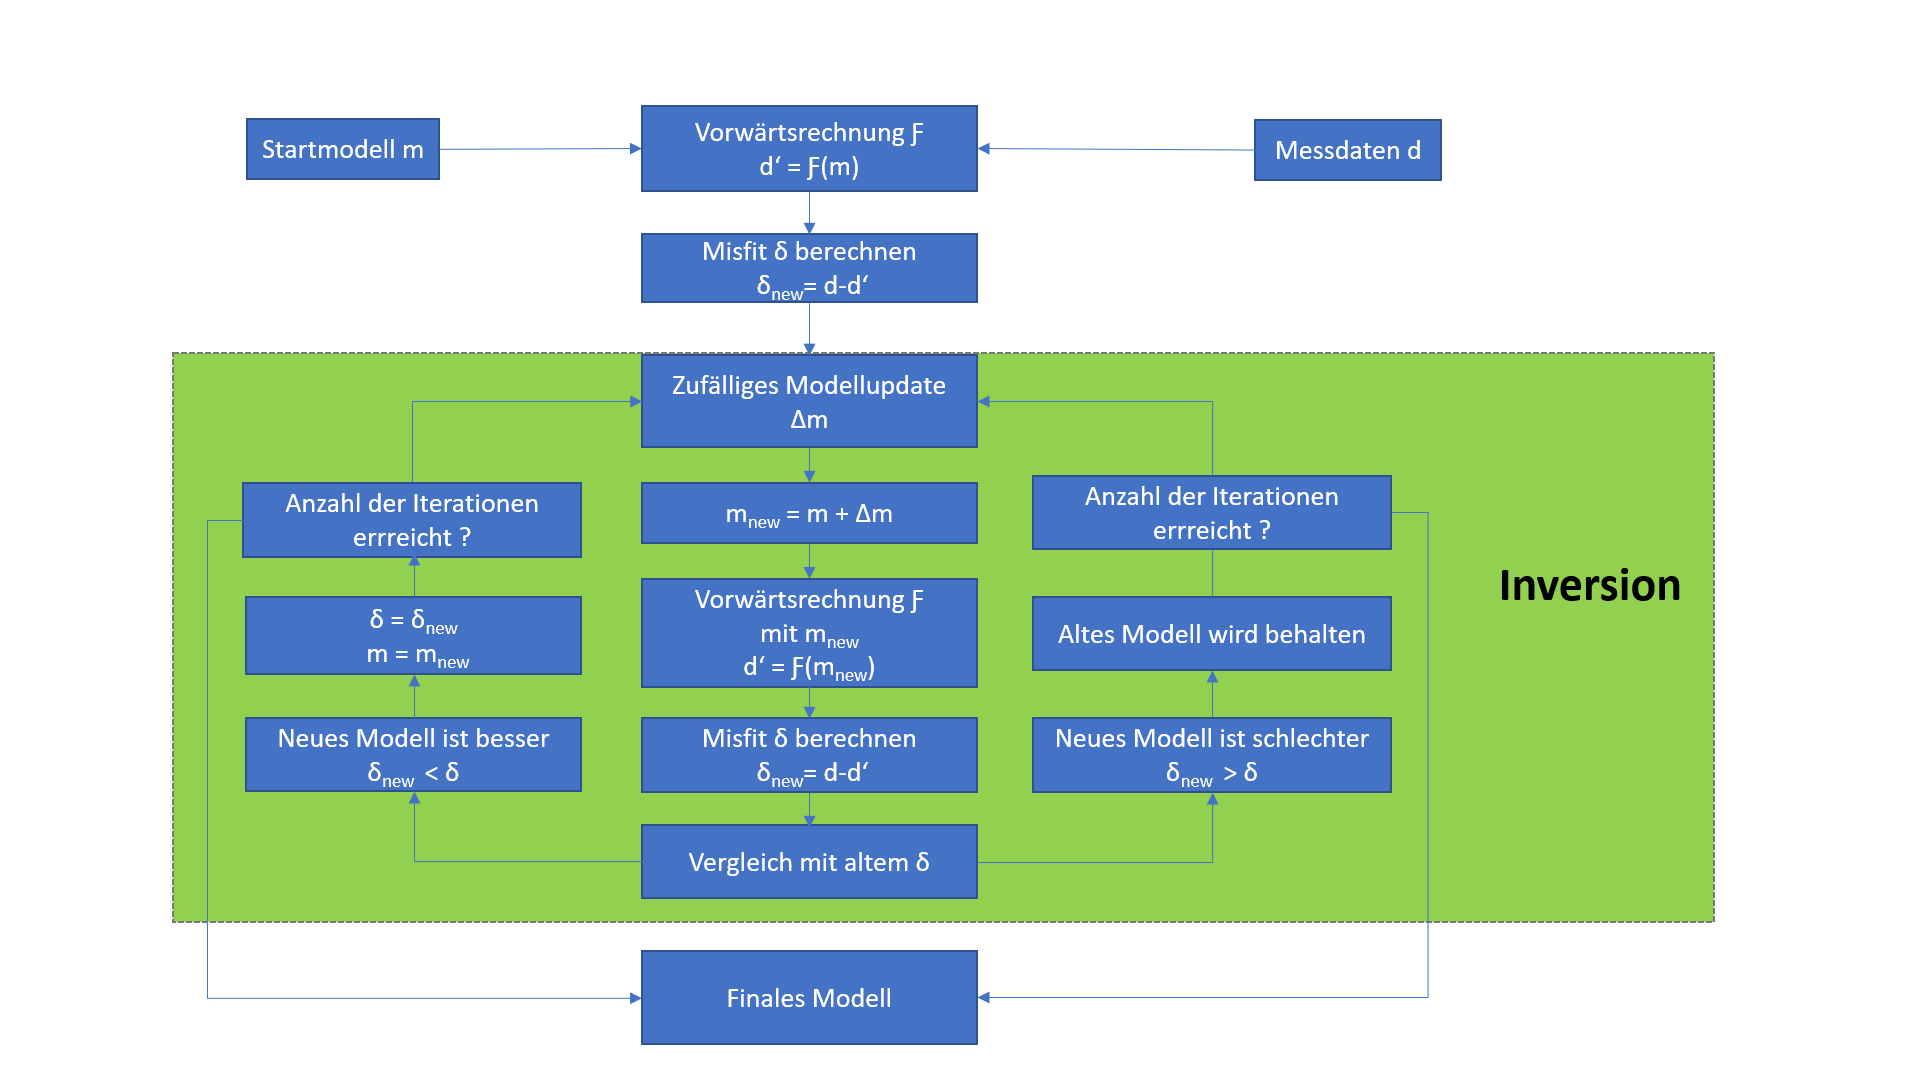

### Geben Sie hier ihre gemessenen Werte für L/2 und den scheinbar spezifischen Widerstand ein und wählen Sie anhand der von Ihnen geplotteten Sondierungskurve ein Startmodell:

Formatbeispiel:a = 10, L/2 = [10,20,30,40] , rho_a = [10,20,30,40]

In [7]:
# Abstand der Potentialsonden
a = 1

# halbe Auslagenlänge
L_halbe = [ ]

# scheinbar spezifischer Widerstand
rho_a = [ ]

# Startmodell: 
# (Achtung: die unterste Schicht wird als Halbraum betrachtet, 
# deshalb muss für die Schichtmächtigkeit ein Wert weniger angegeben werden,
# als für den spez. elektr. Widerstand)

# spezifisch elektrischer Widerstand
rho_start = [ ]; 
# Schichtmächtigkeit
d_start = [ ]; 

print('Fertig. Für das Inversionsergebnis führen Sie die nächste Zelle aus.')

Fertig. Für das Inversionsergebnis führen Sie die nächste Zelle aus.


Berechnet Modell 1 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 1.80 s
Berechnet Modell 2 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 1.80 s
Berechnet Modell 3 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 1.77 s
Berechnet Modell 4 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 1.77 s
Berechnet Modell 5 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 1.77 s
[345.5454843  125.21452837  42.71766123] [0.70071044 6.17169166]
Fertig


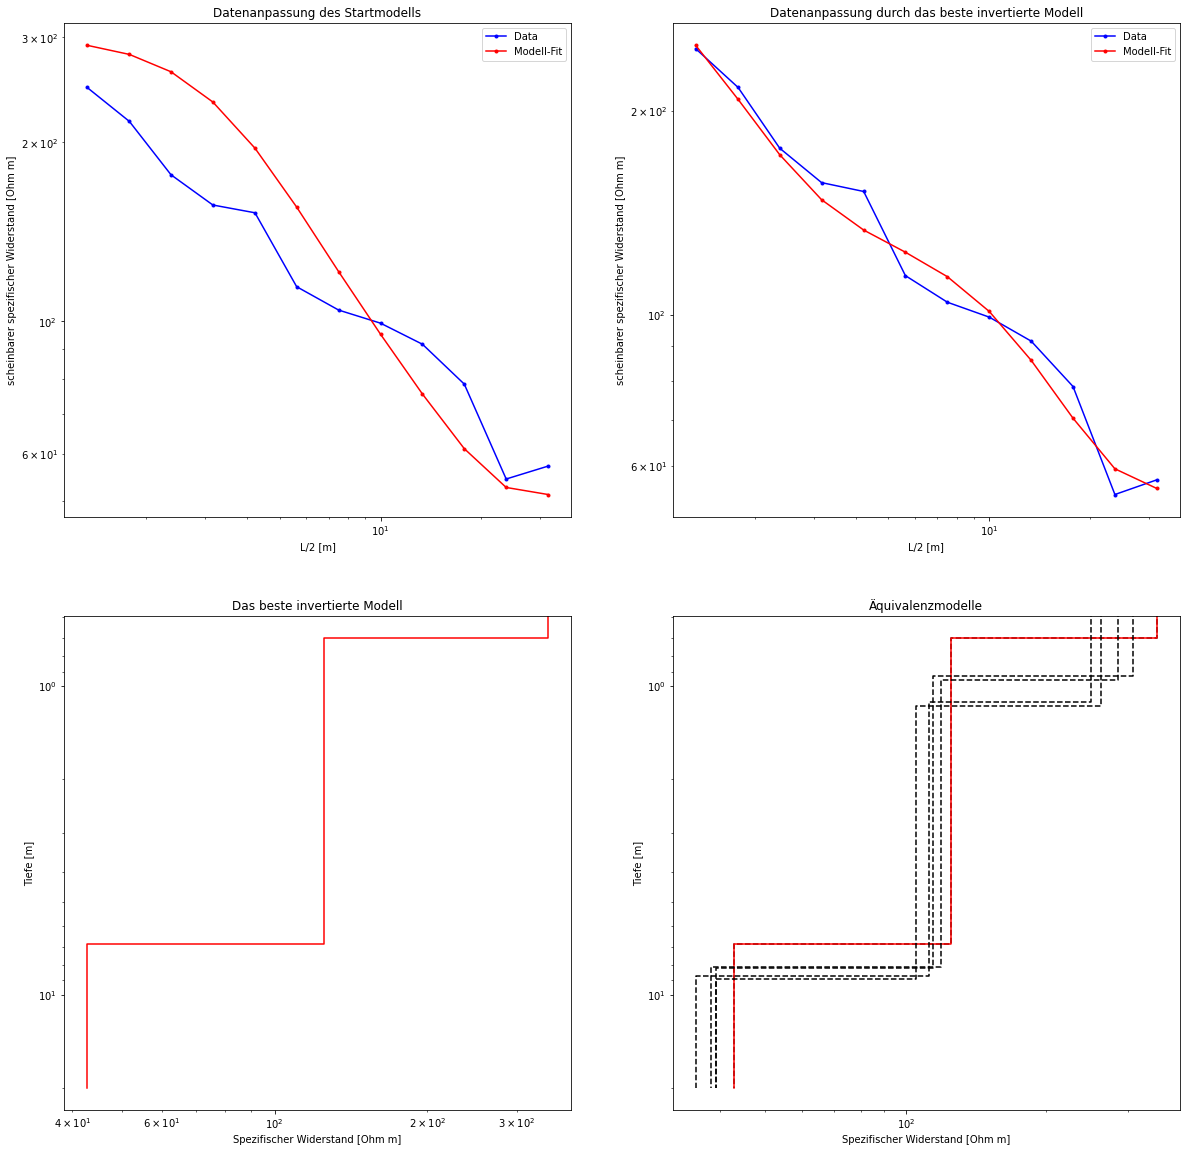

In [8]:
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt
import time
import math

def precompute_bessel_function(L_model,dx,n_max):
    vec = np.arange(0,n_max+dx,dx); 
    bessel = np.zeros([len(L_model),len(vec)])
    for jdx,L in enumerate(L_model):
        for idx,lamb in enumerate(vec):
            bessel[jdx,idx] = scp.jv(1,lamb*L)*lamb
    return bessel

def forward_model_1(rho,d,L_model,bessel,dx,n_max): 
    ''' Berechnet die scheinbaren spezifischen Widerstände für Schichten mit der
        Dicke d und spezifischen Widerständen rho für bestimmte Auslagenlängen L/2 

    © Nepomuk Boitz, Mai 2020, boitz@geophysik.fu-berlin.de
'''
    ## Initialize parameters
    n = len(rho); 
    K = np.zeros([n]); 
    T = np.zeros([n])
    vec1 = np.arange(0,n_max+dx,dx); 
    T_star = np.zeros(len(vec1))
    P = np.zeros([n-1])
    rho_a = np.zeros([len(L_model)])
    temp = np.zeros([n-1,len(vec1)])
    check = np.zeros([n-1,len(vec1)])
    K[n-1] = 1; 
    # Precomputations
    for i in range(0,n-1):
        P[i] = rho[i]/rho[i+1]; 
        for idx,lamb in enumerate(vec1):
            temp[i,idx] = np.tanh(d[i]*lamb)

    vec = np.arange(n-2,-1,-1)
    count = 0; 
    for idx,lamb in enumerate(vec1):  
        for i in vec:
            K[i] = (K[i+1]+P[i]*temp[i,idx])/(P[i] + K[i+1]*temp[i,idx]);
            check[i,idx] = K[i]
        T_star[idx] = rho[0]*check[0,idx];
    
    
    # Forward Modeling     
    for jdx,L in enumerate(L_model):
        fac = 0;
        for idx,lamb in enumerate(vec1):
            fac = fac + (((T_star[idx]-rho[0])*bessel[jdx,idx])*dx);
        fac = rho[0]+L**2*fac; 
        rho_a[count] = fac;   
        count += 1; 

    return rho_a

def invert_model(n_realisation,it_max,start_model,data,dx,n_max):
    history = np.zeros([n_realisation,len(start_model)+1])
    bessel = precompute_bessel_function(data[:,0],dx,n_max)
    n_layer = len(start_model)//2+1
    t_start = time.time()
    for j in range(n_realisation):
        rho = start_model[range(0,len(start_model)//2+1)]; 
        d = start_model[range(len(start_model)//2+1,len(start_model))]; 
        rho_a = forward_model_1(rho,d,data[:,0],bessel,dx,n_max);
        if j == 0:
            plot_single_model(data,rho_a)
            plt.title('Datenanpassung des Startmodells')
            
        misfit = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2); 
        mis = np.zeros(it_max)
        a = time.time()
        for i in range(it_max):
            rho_update = np.random.randn(n_layer)*fac*rho;
            d_update =np.random.randn(n_layer-1)*fac*d;
            rho_a = forward_model_1(rho+rho_update,d+d_update,data[:,0],bessel,dx,n_max);
            mis[i] = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2);
            if (mis[i] < misfit):
                misfit = mis[i];
                rho  = rho+rho_update;
                d = d+d_update;
        history[j,:] = np.concatenate([rho, d,np.array( [mis[i]])]);
        t_end = time.time()
        print('Berechnet Modell %d von insgesamt %d Modellen, durchschnittliche Berechnungsgzeit pro Modell %.2f s' % (j+1,n_realisation,(t_end-t_start)/(j+1)))
    return history

def plot_single_model(data,rho_a): 
    
    plt.loglog(data[:,0],data[:,2],'b.-')
    plt.loglog(data[:,0],rho_a,'r.-')
    plt.xlabel('L/2 [m]')
    plt.ylabel('scheinbarer spezifischer Widerstand [Ohm m]')
    plt.legend(['Data','Modell-Fit'])
    plt.title('Datenanpassung durch das beste invertierte Modell')
    
def plot_equivalent_models(history):
    #fig, ax = plt.subplots(figsize=(8, 8))

    n_layer = np.size(history,1)//2
    for i in range(np.size(history,0)):
        z = np.zeros(2*n_layer)
        rho = np.zeros(2*n_layer)
        for j in range(n_layer):
            rho[range(j*2,j*2+2)] = history[i,j]
        for j in range(n_layer-1):
            z[range(j*2+1,j*2+3)] = history[i,n_layer+j] + z[j]
        z[n_layer*2-1] = 20
        plt.loglog(rho,z,'k--')
        if np.argmin(history[:,np.size(history,1)-1])==i:
            plt.loglog(rho,z,'r-')
    plt.gca().invert_yaxis()
    plt.ylabel('Tiefe [m]')
    plt.xlabel('Spezifischer Widerstand [Ohm m]')
    plt.title('Äquivalenzmodelle')
    
    
def plot_final_model(history):

    n_layer = np.size(history,1)//2
    for i in range(np.size(history,0)):
        z = np.zeros(2*n_layer)
        rho = np.zeros(2*n_layer)
        for j in range(n_layer):
            rho[range(j*2,j*2+2)] = history[i,j]
        for j in range(n_layer-1):
            z[range(j*2+1,j*2+3)] = history[i,n_layer+j] + z[j]
        z[n_layer*2-1] = 20
        #plt.loglog(rho,z,'k--')
        if np.argmin(history[:,np.size(history,1)-1])==i:
            plt.loglog(rho,z,'r-')
    plt.gca().invert_yaxis()
    plt.ylabel('Tiefe [m]')
    plt.xlabel('Spezifischer Widerstand [Ohm m]')
    plt.title('Das beste invertierte Modell')
    
# Messwerte
# Die Werte bitte innerhalb der eckigen Klammern eintragen, getrennt mit einem Komma
# Halber Abstand der Einspeisesonden i 
L_halbe = np.array(L_halbe)

# Abstand der Potentialsonden in Meter
a = a

# Scheinbarer spezifischer Widerstand in Ohm Meter
rho_a = np.array(rho_a)

#-----------------------------------
# Startmodell original
rho_start = np.array(rho_start); 
d_start = np.array(d_start); 
#-----------------------------------

G=np.multiply(math.pi,(np.square(L_halbe)-np.square(a/2)))

# Inversionparameter
dx = .075 # Parameter für das numerische Lösen des Intergrals (am besten so lassen)
n_max = 30; # Paramter für das numerische Lösen des Intergrals (am besten so lassen)
fac = .15; # kontrolliert wie groß ein einzelnes Modellupdate sein soll
it_max = 400; # Anzahl der Modelle pro Iteration die getestet werden
n_realisation = 5 ; # Wie viele Equivalenzmodelle sollen berechnet werden ? 


# Inversion wird gestartet - Ab hier nichts mehr verändern

data = np.column_stack((L_halbe,G,rho_a))
start_model = np.concatenate([rho_start,d_start])
bessel = precompute_bessel_function(data[:,0],dx,n_max)

plt.figure(figsize=(20,20))
#fig, ax = plt.subplots(2, 2)
#fig.tight_layout(h_pad=2)
plt.subplot(2,2,1)
history = invert_model(n_realisation,it_max,start_model,data,dx,n_max)

# Find best model 
plt.subplot(2,2,2)
which_model = np.argmin(history[:,np.size(history,1)-1])

# Plot best model

rho_final = history[which_model,range(0,np.size(history,1)//2)]; 
d_final = history[which_model,range(np.size(history,1)//2,np.size(history,1)-1)]; 
rho_a = forward_model_1(rho_final,d_final,data[:,0],bessel,dx,n_max)
plot_single_model(data,rho_a)

plt.subplot(2,2,3)
plot_final_model(history)

# Plot Equivalent-Models
plt.subplot(2,2,4)
plot_equivalent_models(history)
print(rho_final, d_final)    
    
    
print('Fertig')
    